# Estudio de la evolución de la pandemia por el modelo ARIMA para la isla de La Gomera

En este estudio se analiza la evolución de la pandemia de COVID-19 en la isla de La Gomera y la influencia de factores como los atmosféricas en la evolución de dicha enfermedad. Para este fin se utiliza el modelo ARIMA tanto univariable como multivariable. 

El estudio se fragmenta en 4 partes:
* modelado univariable donde se emplea únicamente la variable objetivo.
* modelado multivariable empleando las variables pandémicas. Dichas variables son:
    * pcr_total: Número total de pruebas PCR realizadas.
    * Urg_cv: Ingresos en el servicio de urgencias por COVID19.
    * HPT_cv19: Ocupación del resto de camas para pacientes COVID.
    * CCR_cv19: Ocupación de las unidades críticas con respirador para pacientes COVID.
* modelado multivariable empleando las variables atmosféricas:
    * tmin: Temperatura mínima diaria.    
    * tmed: Temperatura media diaria.  
    * presMax: Presión máxima al nivel de la estación.   
* modelado multivariable con todas las variables.

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def visualizar_STL(df):
    ''' Visualiza el gráfico STL con la descomposición en tendencia, estacionalidad y residuos de la serie temporal
    
    Args:
        df (DataFrame): DataFrame con los datos a realizar el estudio (DataFrame con una única columna que es la objetivo)
    '''
    stl = STL(df, period=12)
    res = stl.fit()
    
    fig = res.plot()

    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))

    plt.xticks(rotation=90)
    plt.show()
    

def visualizar_adf(df):
    ''' Visualiza el p-valor del estudio de Dickey-Fuller para determinar la estacionalidad de los datos
    
    Args:
        df (DataFrame): DataFrame con los datos a realizar el estudio (DataFrame con una única columna que es la objetivo)
    '''

    adf = adfuller(df)
    print("ADF p-value:" + str(adf[1]))
    

def visualizar_acf(df, n_lags):
    ''' Método que visualiza un gráfico con la autocorrelación de los datos con los n rezagos anteriores
    
    Args:
        df (DataFrame): Dataframe con los datos a realizar ele studio de autocorrelación parcial
        n_lags (integer): Número de rezagos a analizar
    '''
    plt.figure(figsize=(16, 10))
    plot_acf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación')
    plt.title('ACF')
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.show()
    
def visualizar_pacf(df, n_lags):
    ''' Método que visualiza un gráfico con la autocorrelación parcial de los datos con los n rezagos anteriores
    
    Args:
        df (DataFrame): Dataframe con los datos a realizar ele studio de autocorrelación parcial
        n_lags (integer): Número de rezagos a analizar
    '''
    plt.figure(figsize=(16, 6))
    plot_pacf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación parcial')
    plt.title('PACF')
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.show()
    
    
def visualizar_dif_pred_test(test, pred, variable, tit):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
    
    Args:
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
        tit(string): título del gráfico
    '''
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(test.index, test, label='Test', color='green')
    plt.plot(test.index, pred, label='Predicción', color='orange')

    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.xticks(rotation=60)
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, tit, color, dif):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
        y muestra el historico de casos en función del número de días que indiquemos que muestre
    
    Args:
        train (DataFrame): Conjunto de datos de entrenamiento
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable (string): Variable objetivo
        dias_historico (integer): días hacia atrás a mostrar del historico
        tit (string): título del gráfico
        color (string): color de la isla para visualizar
    '''
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color)
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color)
        plt.plot(test.index, test, label='Test', color='green')
    
    plt.plot(test.index, pred, label='Predicción', color='orange')
    plt.bar(test.index, dif, width=0.5, color='black', alpha=0.2, align='edge', label='Diferencia')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(test.index), step=5),   train_s.index.union(test.index)[::5], rotation=70)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_bic_aic(modelo):
    ''' Visualiza los datos de BIC (Criterio de Información Bayesiano) y  AIC (Criterio de Información de Akaike)
    
    Args:
        modelo (ARIMA): modelo ARIMA entrenado
    '''
    
    bic = modelo.bic
    aic = modelo.aic

    print("BIC del modelo ARIMA:", bic)
    print("AIC del modelo ARIMA:", aic)
    
def visualizar_resultados_texto(y_test, y_pred, variable):
    ''' Método que visualiza por pantalla en formato de texto el número de csaos reales y los predichos por el algoritmo
    
    Args:
        y_test (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
    '''
    fechas = y_test.index
    for i in range(len(y_test)):
        if variable != '':
            valor_test = y_test[variable][i]
        else:
            valor_test = y_test[i] 
        print(str(fechas[i]) + ': número de casos reales ' + str(valor_test) + ', número de casos predichos ' + str(y_pred[i]))
        
def obtener_df_diferencias(test, pred, variable):
    ''' Obtiene la diferencia entre los valores de test y los predichos
    
    Args:
        test (Serie): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
    '''
    df_result = test.copy()
    if variable != '':
        df_result = df_result[variable]
        df_result = df_result.to_frame()
    else:
        df_result = df_result.to_frame()
    df_result['pred'] = 0
    df_result['dif'] = 0

    for i in range(len(df_result)):
        df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
        df_result.iloc[i, df_result.columns.get_loc('dif')] = df_result['numero_casos'][i] - pred[i]
        
    return df_result

Inicialmente cargamos los datos del fichero con los datos procesados anteriormente y obtenemos los datos únicamente para la isla de La Gomera.

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos_islas = pd.read_csv('../data/Final/datos_reduc_final.csv', header=0)

# Obtenemos los datos de la isla a la que se le va a realizar el estudio
datos_LaGomera = datos_islas[datos_islas['isla'] == 'LA GOMERA'].copy()


datos_LaGomera = datos_LaGomera.sort_values(by='fecha')    # Ordenamos por fecha por si los datos devueltos no estuvieran en orden
datos_LaGomera.set_index('fecha', inplace=True)           # Añadimos como índice de los datos la fecha


In [4]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
n_dias = 10               # Número de días correspondiente al conjunto de TEST
n_dias_train_vis = 100    # Número de días del conjunto de train a visualizar en el conjunto de train
color_isla = 'olive'       # Color de la isla en las visualizaciones
isla = 'La Gomera'        # Nombre de la isla para las visualizaciones    

variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']   # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                         # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables

Separamos los datos en función de las variables a emplear en cada uno de los estudios que se van a realizar.

In [5]:
# Obtenemos los conjuntos de datos para cada modelo con las variables necesarias para cada uno de ellos

datos_LaGomera_arima_uni = datos_LaGomera[objetivo]               # Datos modelo Univariable
datos_LaGomera_arima_mult_covid = datos_LaGomera[[objetivo] + variables_covid] # Datos modelo Multivariable con datos pandémicos
datos_LaGomera_arima_mult_atm = datos_LaGomera[[objetivo] + variables_atm]     # Datos modelo Multivariable con datos atmosféricos
datos_LaGomera_arima_total = datos_LaGomera.copy()                # Datos modelo Multivariable con todos los datos

Descomponemos la serie temporal en sus tres componentes principales: tendencia, estacionalidad y residuos.

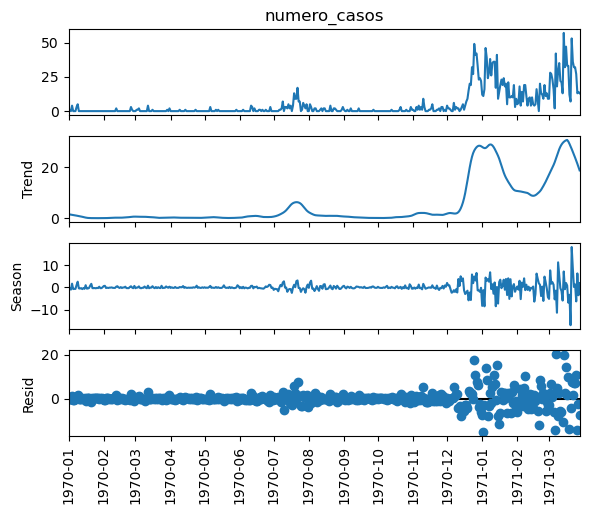

In [6]:
visualizar_STL(datos_LaGomera_arima_uni)

Para aplicar el modelo de ARIMA debemos de investigar los valores óptimos iniciales para los parámetros p,d,q los cuales equivalen a Autorregresivo (AR), Integrado (I), Promedio Móvil (MA). Para obtener el parámetro óptimo realizaremos diferentes estudios: 
* Para el parámetro d realizamos la prueba de Dickey-Fuller para determinar la estacionalidad de los datos de forma que si los datos son no estacionarios debemos de aplicar diferenciaciones hasta obtener una serie temporal, siendo este número de diferenciaciones el valor de d. Si la serie temporal ya era estacionaria el valor será 0.
* Para el parámetro q emplearemos la función de autocorrelación donde se estudia la correlación de los datos de la serie temporal con sus rezagos, de forma que el rezago anterior a que entre en la zona de confianza equivaldrá a nuestro parámetro óptimo.
* Para el parámetro p utilizamos la función de autocorrelación parcial que al igual que el parámetro anterior el rezago anterior a aquel que entre en la zona de confianza será el valor inicial ópti.
io.

En primer lugar realizamos la prueba de Dickey-Fuller para verificar si la serie temporal es estacionaria.

In [7]:
visualizar_adf(datos_LaGomera_arima_uni)

ADF p-value:0.23457306487474738


Realizamos una diferenciación de la serie temporal y realizamos de nuevo la prueba de Dickey-Fuller.

In [8]:
datos_LaGomera_arima_uni_1d = datos_LaGomera_arima_uni.diff().dropna()
visualizar_adf(datos_LaGomera_arima_uni_1d)

ADF p-value:1.6267026878849003e-06


Para la isla de La Gomera es necesaria una diferenciación para poder obtener una serie temporal estacionaria por lo que el parámetro d es 1.

Una vez ajustado el parámetro d realizamos un análisis de la Función de autocorrelación (ACF) para medir la correlación de la serie temporal y sus valores rezagados para determinar el valor de q.

<Figure size 1600x1000 with 0 Axes>

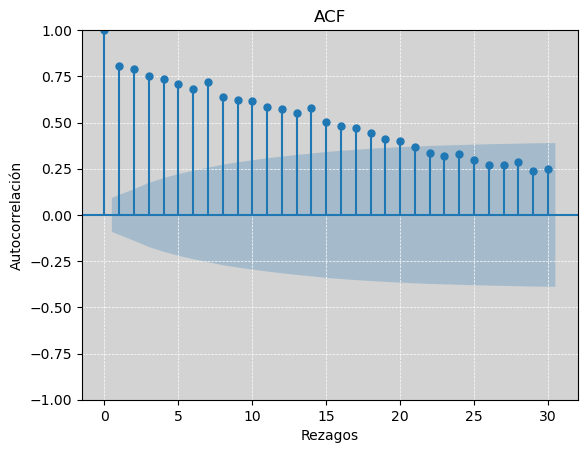

In [9]:
visualizar_acf(datos_LaGomera_arima_uni, 30)

Por último realizamos un análisis de la Función e Autocorrelación Parcial (PACF) para determinar el valor de p.

<Figure size 1600x600 with 0 Axes>

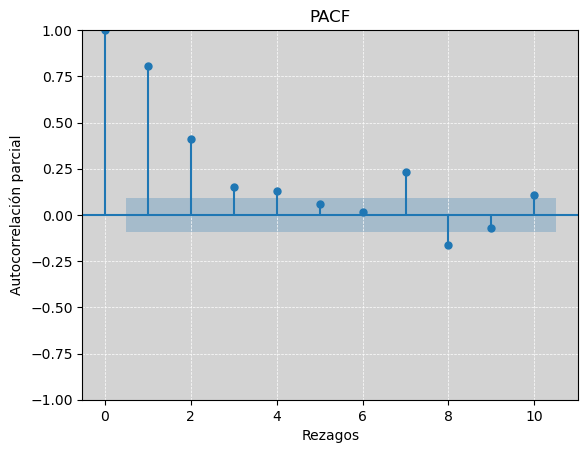

In [10]:
visualizar_pacf(datos_LaGomera_arima_uni, 10)

Una vez analizados los mejores valores para los parámetros realizamos pruebas con estos valores para comprobar sus resultados y posteriormente iremos modificando dichos parámetros para determinar si se ajusta mejor el algoritmo con la modificación de estos parámetros.

Tras finalizar las pruebas con diferentes valores para los parámetros, podemos determinar que los mejores resultados se obtienen con los siguientes valores de parámetro:

In [11]:
# Parámetros del modelo ARIMA
p = 5   # Parámetro Autorregresivo (AR)
d = 1   # Parámetro Integrado (I)
q = 7   # Parámetro Promedio Movil (MA)

# Modelo ARIMA univariable

Realizamos el análisis con los datos únicamente de la variable objetivo obteniendo un modelo ARIMA univariable.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [12]:
# Conjuntos de entrenamiento y test
train = datos_LaGomera_arima_uni.iloc[:len(datos_LaGomera_arima_uni) - n_dias]
test =  datos_LaGomera_arima_uni.iloc[len(datos_LaGomera_arima_uni) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [13]:
arima_LaGomera = ARIMA(endog=train, order=(p, d, q), freq = 'D')
modelo_arima_LaGomera = arima_LaGomera.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Como medida de validación del modelo visualizamos los resuldatos del criterio de información Bayesiano (BIC) y el criterio de información Akaike(AIC).

In [14]:
visualizar_bic_aic(modelo_arima_LaGomera)

BIC del modelo ARIMA: 2668.521672138928
AIC del modelo ARIMA: 2615.3640887581187


Evaluamos los residuos del modelo mediante la función de autocorrelación para determinar la correlación entre los residuos, si existe una fuerte correlación entre ellos implicaría que el modelo no está bien ajustado.

<Figure size 1600x1000 with 0 Axes>

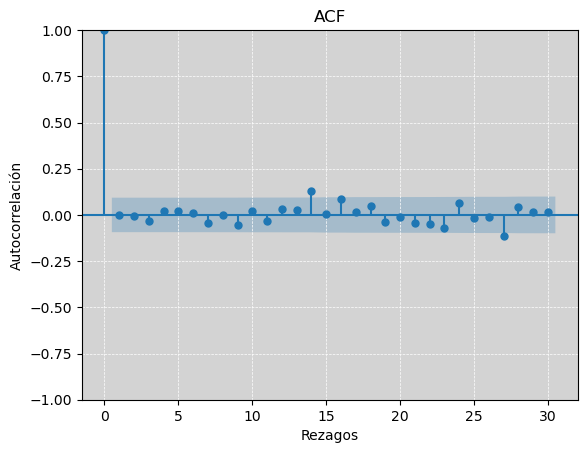

In [15]:
visualizar_acf(modelo_arima_LaGomera.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [16]:
pred = modelo_arima_LaGomera.forecast(steps=n_dias)

Visualizamos una comparación entre los valores reales y los valores predichos.

In [17]:
visualizar_resultados_texto(test, pred, '')

2022-03-19: número de casos reales 12, número de casos predichos 34.39237993589069
2022-03-20: número de casos reales 7, número de casos predichos 29.74671681833233
2022-03-21: número de casos reales 53, número de casos predichos 39.67690432450305
2022-03-22: número de casos reales 36, número de casos predichos 29.61335446935673
2022-03-23: número de casos reales 32, número de casos predichos 31.16128647618502
2022-03-24: número de casos reales 32, número de casos predichos 36.37294794823087
2022-03-25: número de casos reales 27, número de casos predichos 30.671678027422665
2022-03-26: número de casos reales 13, número de casos predichos 32.21771100128616
2022-03-27: número de casos reales 14, número de casos predichos 30.272220941073854
2022-03-28: número de casos reales 13, número de casos predichos 34.87846938295674


Graficamos la diferencia entre los valores de test y los predichos.

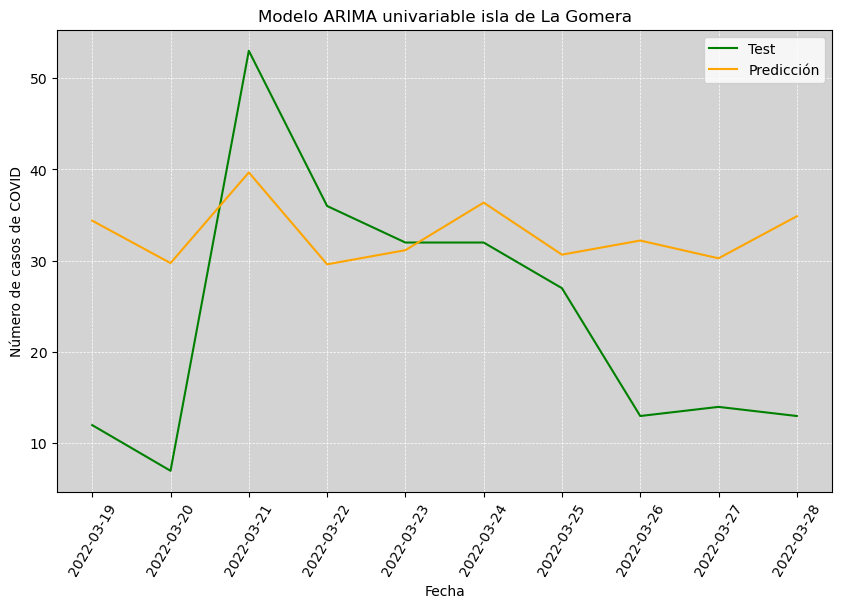

In [18]:
# Título para las visualizaciones
tit = 'Modelo ARIMA univariable isla de ' + isla
visualizar_dif_pred_test(test, pred, '', tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [19]:
df_result = obtener_df_diferencias(test, pred, '')
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,12,34.392380,-22.392380
2022-03-20,7,29.746717,-22.746717
2022-03-21,53,39.676904,13.323096
2022-03-22,36,29.613354,6.386646
2022-03-23,32,31.161286,0.838714
2022-03-24,32,36.372948,-4.372948
2022-03-25,27,30.671678,-3.671678
2022-03-26,13,32.217711,-19.217711
2022-03-27,14,30.272221,-16.272221


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

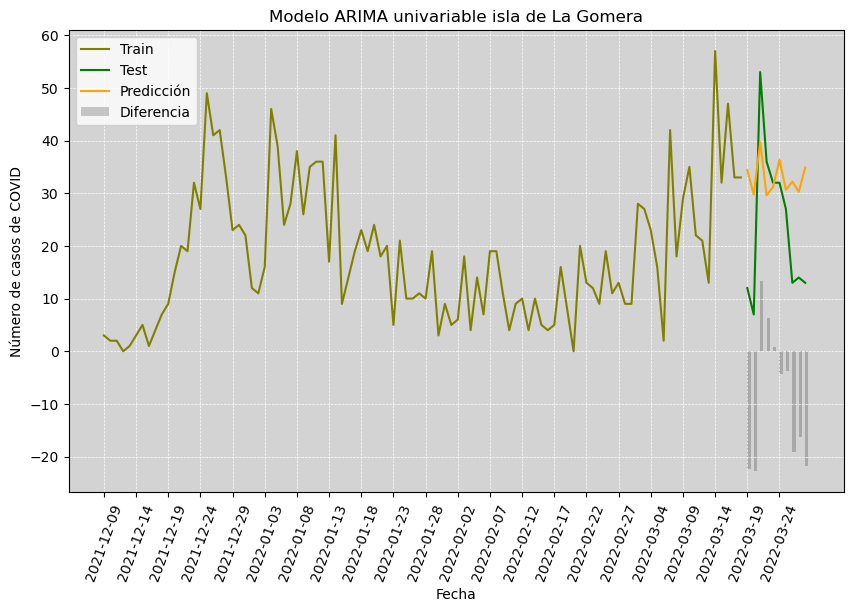

In [20]:
visualizar_historico(train, test, pred, '', n_dias_train_vis, tit, color_isla, df_result['dif'])

Para la evaluación del modelo se utilizarán las siguientes estimadores:
* MAE: Error absoluto medio
* MSE: Error cuadrático medio 
* RMSE: Raíz del error cuadrático medio 

In [21]:
mae, mse, rmse = obtener_errores(test, pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 238.3206271414292
Error absoluto medio (MAE) del modelo: 13.110057878514851
Raíz del error cuadrático medio (RMSE) del modelo: 15.437636708428826


# Modelo ARIMA multivariable con variables de pandemia

Realizamos el análisis con los datos pandémicos obteniendo un modelo ARIMA multivariable en base a dichas variables.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [22]:
train = datos_LaGomera_arima_mult_covid.iloc[:len(datos_LaGomera_arima_mult_covid) - n_dias]
test =  datos_LaGomera_arima_mult_covid.iloc[len(datos_LaGomera_arima_mult_covid) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [23]:
arima_LaGomera = ARIMA(endog=train[objetivo],exog=train[variables_covid], order=(p, d, q), freq = 'D')
modelo_arima_LaGomera = arima_LaGomera.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Visualizamos los resultados de los criterios BIC y AIC.

In [24]:
visualizar_bic_aic(modelo_arima_LaGomera)

BIC del modelo ARIMA: 2612.854031100322
AIC del modelo ARIMA: 2543.3402682177257


Evaluamos los residuos del modelo con la función de autocorrelación.

<Figure size 1600x1000 with 0 Axes>

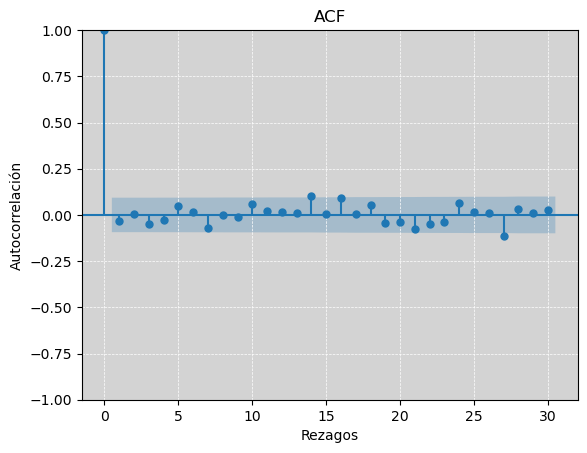

In [25]:
visualizar_acf(modelo_arima_LaGomera.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [26]:
pred = modelo_arima_LaGomera.forecast(steps=n_dias, exog=test[variables_covid])

Visualizamos una comparación entre los valores reales y los valores predichos.

In [27]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 12, número de casos predichos 31.881109387866825
2022-03-20: número de casos reales 7, número de casos predichos 28.188061524586665
2022-03-21: número de casos reales 53, número de casos predichos 39.779909267034675
2022-03-22: número de casos reales 36, número de casos predichos 31.765890553637515
2022-03-23: número de casos reales 32, número de casos predichos 30.28243175255393
2022-03-24: número de casos reales 32, número de casos predichos 37.36609130932171
2022-03-25: número de casos reales 27, número de casos predichos 28.21938097484202
2022-03-26: número de casos reales 13, número de casos predichos 27.948921338873173
2022-03-27: número de casos reales 14, número de casos predichos 29.447565226494664
2022-03-28: número de casos reales 13, número de casos predichos 28.84001367843959


Graficamos la diferencia entre los valores de test y los predichos.

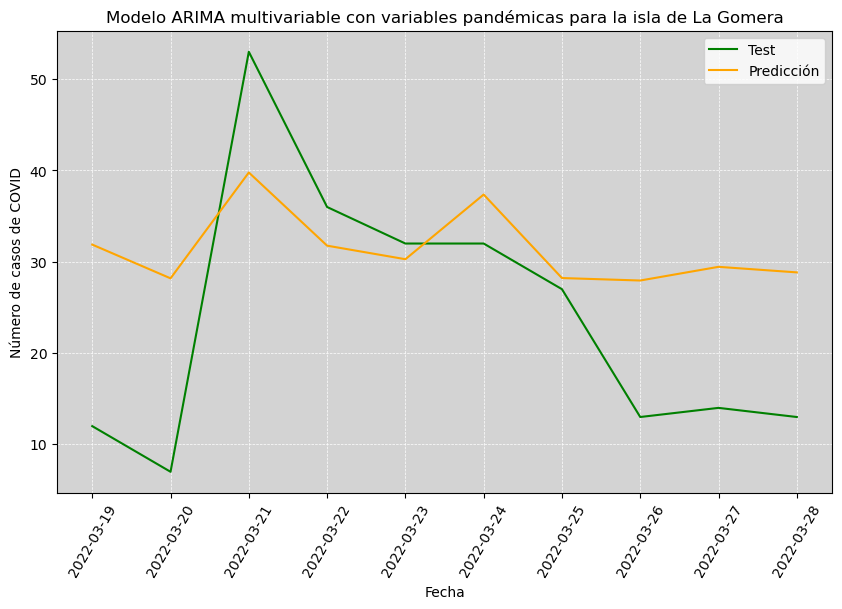

In [28]:
tit = 'Modelo ARIMA multivariable con variables pandémicas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [29]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,12,31.881109,-19.881109
2022-03-20,7,28.188062,-21.188062
2022-03-21,53,39.779909,13.220091
2022-03-22,36,31.765891,4.234109
2022-03-23,32,30.282432,1.717568
2022-03-24,32,37.366091,-5.366091
2022-03-25,27,28.219381,-1.219381
2022-03-26,13,27.948921,-14.948921
2022-03-27,14,29.447565,-15.447565


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

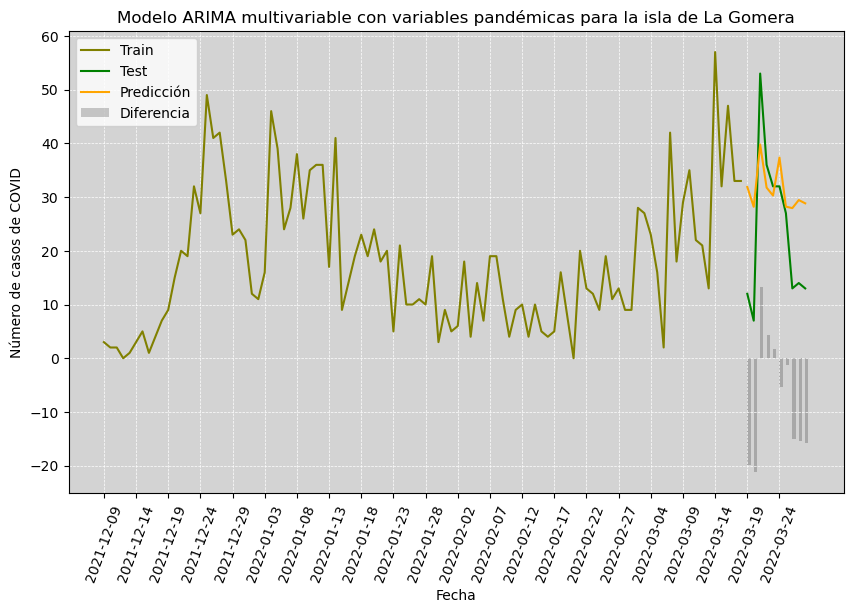

In [30]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

Evaluamos los resultados con las métricas comentadas anteriormente.

In [31]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 178.31263639958058
Error absoluto medio (MAE) del modelo: 11.306291186719852
Raíz del error cuadrático medio (RMSE) del modelo: 13.35337546838179


# Modelo ARIMA multivariable con variables atmosféricas

Realizamos el análisis con los datos atmosféricos obteniendo un modelo ARIMA multivariable en base a dichas variables.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [32]:
train = datos_LaGomera_arima_mult_atm.iloc[:len(datos_LaGomera_arima_mult_atm) - n_dias]
test =  datos_LaGomera_arima_mult_atm.iloc[len(datos_LaGomera_arima_mult_atm) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [33]:
arima_LaGomera = ARIMA(endog=train[objetivo],exog=train[variables_atm], order=(p, d, q), freq = 'D')
modelo_arima_LaGomera = arima_LaGomera.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Visualizamos los resultados de los criterios BIC y AIC.

In [34]:
visualizar_bic_aic(modelo_arima_LaGomera)

BIC del modelo ARIMA: 2682.416842804678
AIC del modelo ARIMA: 2616.992124797528


Evaluamos los residuos del modelo con la función de autocorrelación.

<Figure size 1600x1000 with 0 Axes>

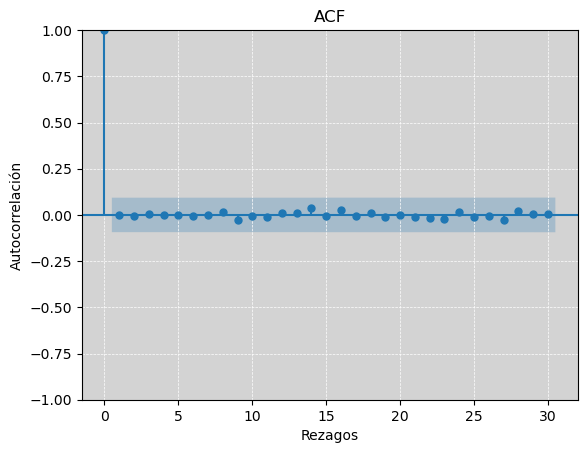

In [35]:
visualizar_acf(modelo_arima_LaGomera.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [36]:
pred = modelo_arima_LaGomera.forecast(steps=n_dias, exog=test[variables_atm])

Visualizamos una comparación entre los valores reales y los valores predichos.

In [37]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 12, número de casos predichos 34.63111511030982
2022-03-20: número de casos reales 7, número de casos predichos 30.180809578620682
2022-03-21: número de casos reales 53, número de casos predichos 39.49432100160652
2022-03-22: número de casos reales 36, número de casos predichos 30.211503223538813
2022-03-23: número de casos reales 32, número de casos predichos 30.795194392683584
2022-03-24: número de casos reales 32, número de casos predichos 36.77456513732582
2022-03-25: número de casos reales 27, número de casos predichos 31.421348335028398
2022-03-26: número de casos reales 13, número de casos predichos 33.21324233775826
2022-03-27: número de casos reales 14, número de casos predichos 32.4383128113418
2022-03-28: número de casos reales 13, número de casos predichos 35.621404501905914


Graficamos la diferencia entre los valores de test y los predichos.

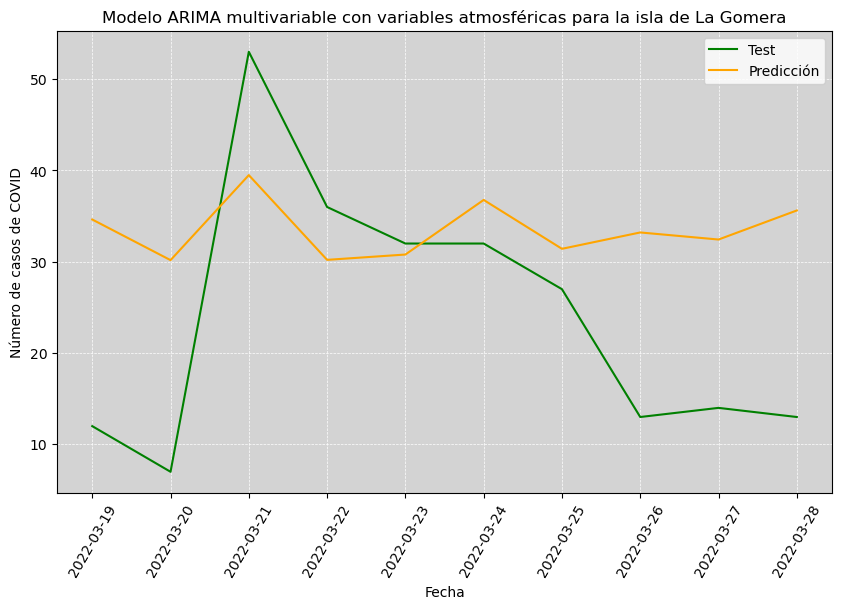

In [38]:
tit = 'Modelo ARIMA multivariable con variables atmosféricas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [39]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,12,34.631115,-22.631115
2022-03-20,7,30.180810,-23.180810
2022-03-21,53,39.494321,13.505679
2022-03-22,36,30.211503,5.788497
2022-03-23,32,30.795194,1.204806
2022-03-24,32,36.774565,-4.774565
2022-03-25,27,31.421348,-4.421348
2022-03-26,13,33.213242,-20.213242
2022-03-27,14,32.438313,-18.438313


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

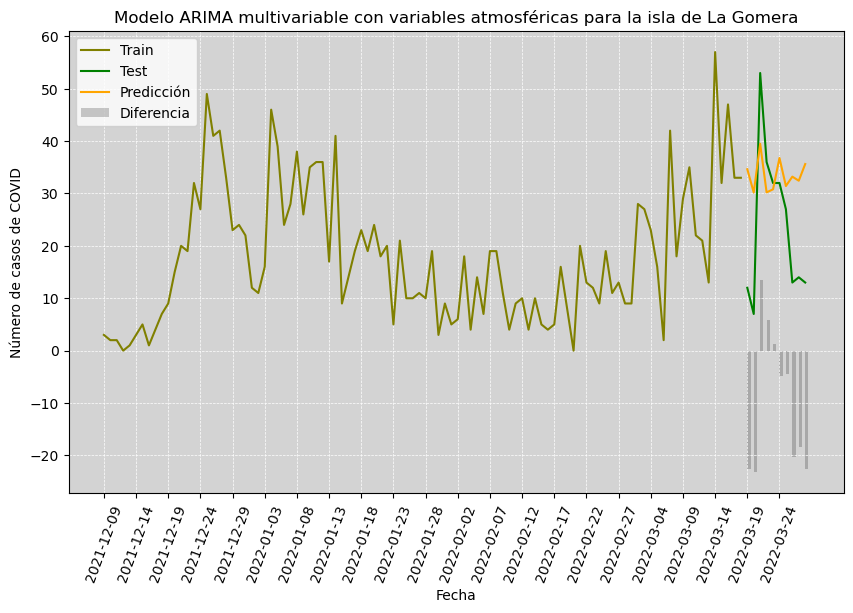

In [40]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

Evaluamos los resultados con las métricas comentadas anteriormente.

In [41]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 256.9498200669444
Error absoluto medio (MAE) del modelo: 13.677977919446178
Raíz del error cuadrático medio (RMSE) del modelo: 16.02965439636627


# Modelo ARIMA multivariable con todas las variables

Realizamos el análisis unificando los datos tanto pandémicos como atmosféricos.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [42]:
train = datos_LaGomera_arima_total.iloc[:len(datos_LaGomera_arima_total) - n_dias]
test =  datos_LaGomera_arima_total.iloc[len(datos_LaGomera_arima_total) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [43]:
arima_LaGomera = ARIMA(endog=train[objetivo],exog=train[variables], order=(p, d, q), freq = 'D')
modelo_arima_LaGomera = arima_LaGomera.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Visualizamos los resultados de los criterios BIC y AIC.

In [44]:
visualizar_bic_aic(modelo_arima_LaGomera)

BIC del modelo ARIMA: 2625.0876449815783
AIC del modelo ARIMA: 2543.3067474726413


Evaluamos los residuos del modelo con la función de autocorrelación.

<Figure size 1600x1000 with 0 Axes>

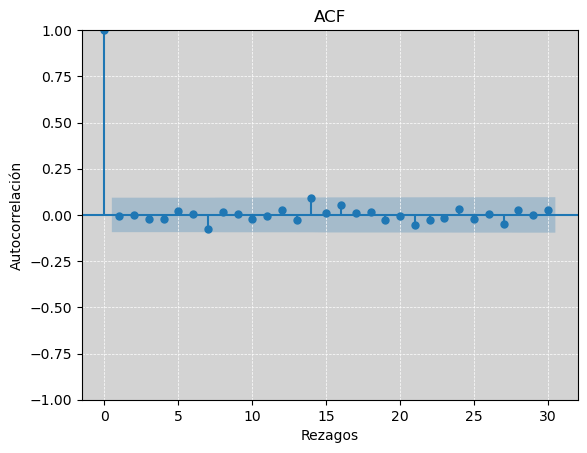

In [45]:
visualizar_acf(modelo_arima_LaGomera.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [46]:
pred = modelo_arima_LaGomera.forecast(steps=10, exog=test[variables])

Visualizamos una comparación entre los valores reales y los valores predichos.

In [47]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 12, número de casos predichos 31.471881533480953
2022-03-20: número de casos reales 7, número de casos predichos 28.23799348527872
2022-03-21: número de casos reales 53, número de casos predichos 40.683006965790284
2022-03-22: número de casos reales 36, número de casos predichos 30.89447240403264
2022-03-23: número de casos reales 32, número de casos predichos 31.150585828405625
2022-03-24: número de casos reales 32, número de casos predichos 37.3015855542731
2022-03-25: número de casos reales 27, número de casos predichos 29.047794915004445
2022-03-26: número de casos reales 13, número de casos predichos 29.51244503440664
2022-03-27: número de casos reales 14, número de casos predichos 29.91566606133567
2022-03-28: número de casos reales 13, número de casos predichos 31.3354525711092


Graficamos la diferencia entre los valores de test y los predichos.

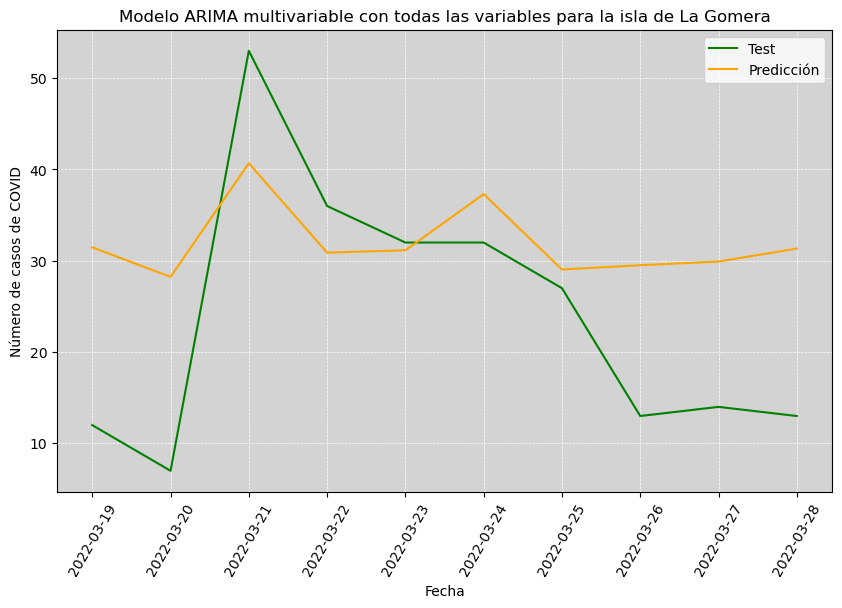

In [48]:
tit = 'Modelo ARIMA multivariable con todas las variables para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [49]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,12,31.471882,-19.471882
2022-03-20,7,28.237993,-21.237993
2022-03-21,53,40.683007,12.316993
2022-03-22,36,30.894472,5.105528
2022-03-23,32,31.150586,0.849414
2022-03-24,32,37.301586,-5.301586
2022-03-25,27,29.047795,-2.047795
2022-03-26,13,29.512445,-16.512445
2022-03-27,14,29.915666,-15.915666


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

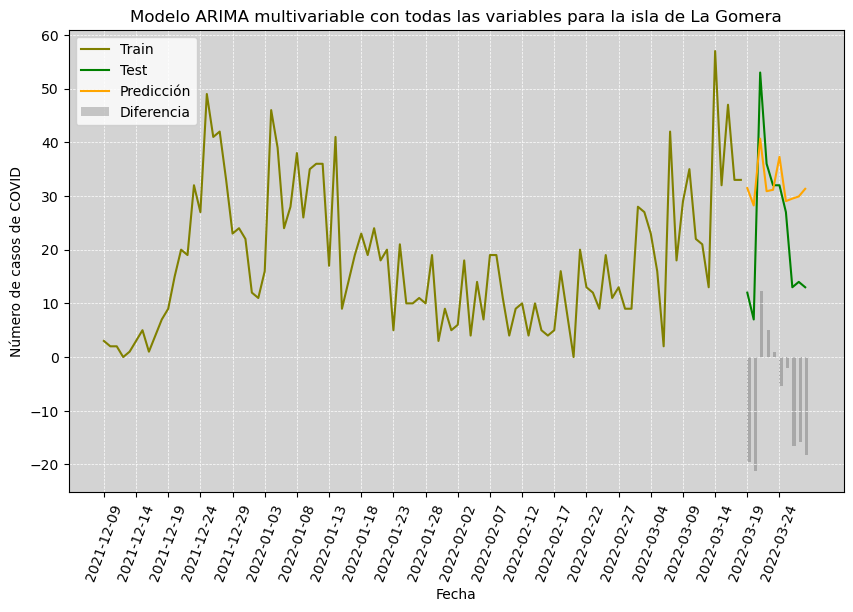

In [50]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

Evaluamos los resultados con las métricas comentadas anteriormente.

In [51]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 190.31611331883613
Error absoluto medio (MAE) del modelo: 11.709475395666018
Raíz del error cuadrático medio (RMSE) del modelo: 13.795510621895666
